In [1]:
import katdal
import matplotlib.pyplot as plt
import numpy
import scape
import os

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.delaunay module was deprecated in version 1.4. Use matplotlib.tri.Triangulation instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Some constant values

In [2]:
# Boltzman constant
k = 1.38e-23
# L-band receptors
receptor_serial={
'm062':{'band':'l', 'serial':4001},
'm063':{'band':'l', 'serial':4002},
'm031':{'band':'l', 'serial':4005},
'm034':{'band':'l', 'serial':4010},
'm024':{'band':'l', 'serial':4},
'm025':{'band':'l', 'serial':4003}}
# Name of directory containing noise diode model files
nd_models ='/var/kat/katconfig/user/noise-diode-models/mkat'

Read observation file

In [3]:
filename='/var/kat/archive/data/MeerKATAR1/telescope_products/2016/03/17/1458200956.h5'   # 20160317-0030
try:
    h5 = katdal.open(filename, quicklook=True)
except Exception as err_msg: raise SystemExit('An error as occured:\n%s' % err_msg)

Using the noise models from EMSS calculations

Approximate Tsys $\approx$ Tant

In [4]:
def modelTcal(noisefile, verbose=False):
    ##Read data from file
    fin = open(noisefile, 'r')
    # Read and ignore header line
    fin.readline()
    fin.readline()
    # Read model data [freq Hz, Te K]
    nd_freqs = []
    nd_temps = []
    for line in fin.readlines():
        try:
            noisemodel= numpy.array(line.strip().split(','), dtype=float)
        except: print line.strip()
        nd_freqs.append(noisemodel[0])
        nd_temps.append(noisemodel[1])
    fin.close()
    nd_freqs = numpy.array(nd_freqs)
    nd_temps = numpy.array(nd_temps)

    coefficients  = numpy.polyfit(nd_freqs, nd_temps, 1)
    polynomial    = numpy.poly1d(coefficients)
    Tcal_passband = numpy.array(polynomial(passband))

    return [nd_freqs, nd_temps, Tcal_passband]

Display data

GPS observation: GPS BIIR-3  (PRN 11)
Observation data for antenna m063
Expected power spectral density of the system noise floor -184 [dBm/Hz]
Observation data for antenna m062


Expected power spectral density of the system noise floor -185 [dBm/Hz]
Observation data for antenna m034


Expected power spectral density of the system noise floor -185 [dBm/Hz]
Observation data for antenna m031


Expected power spectral density of the system noise floor -185 [dBm/Hz]


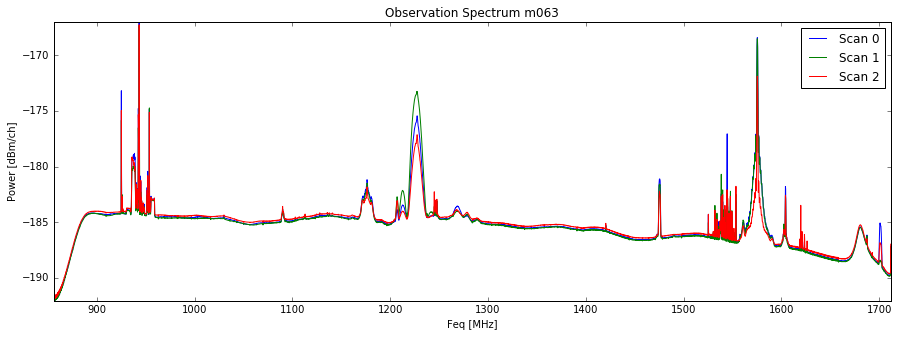

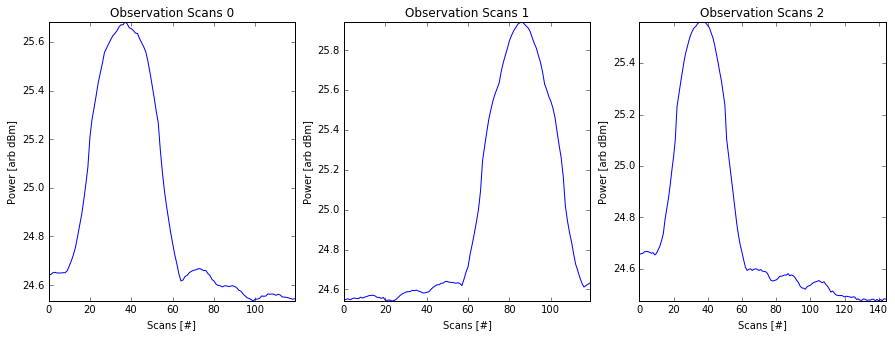

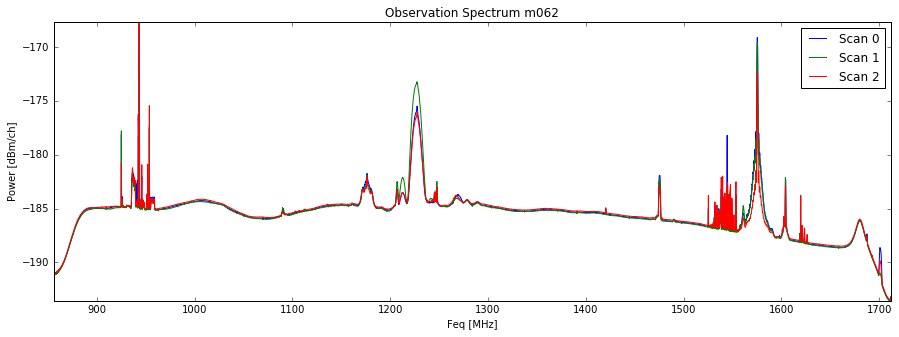

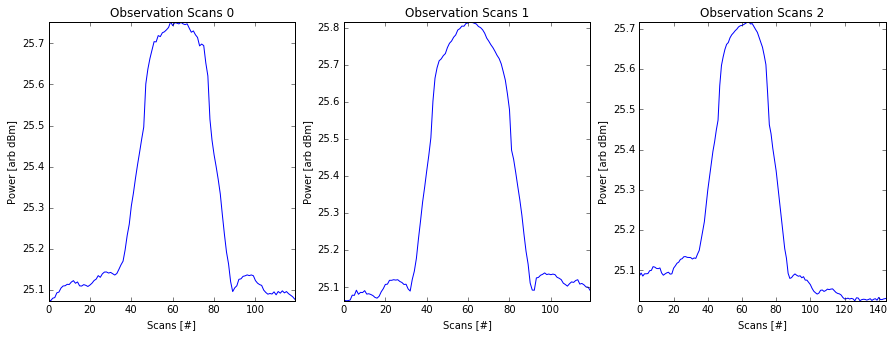

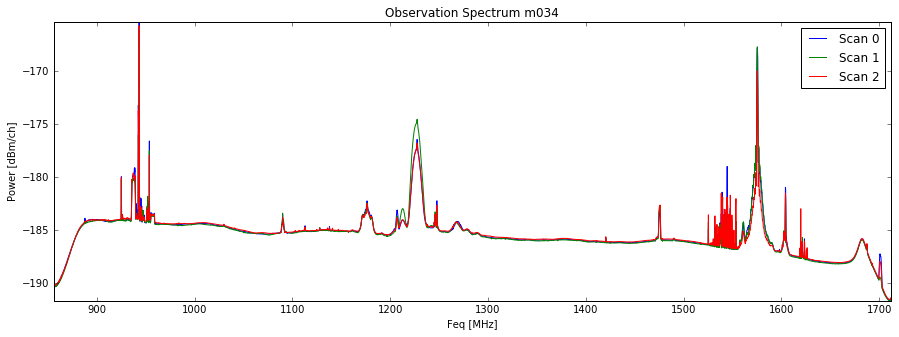

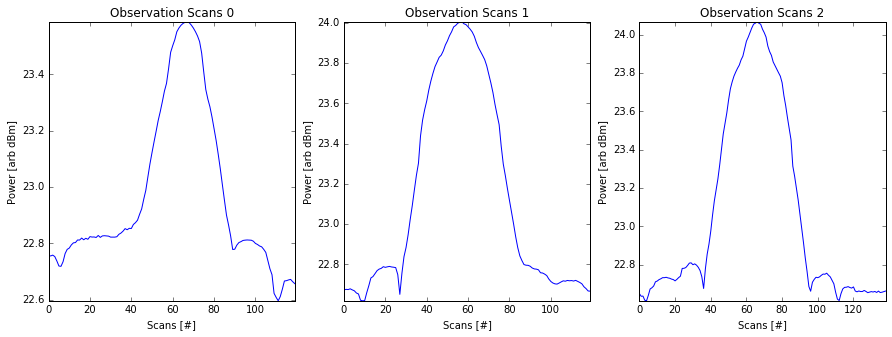

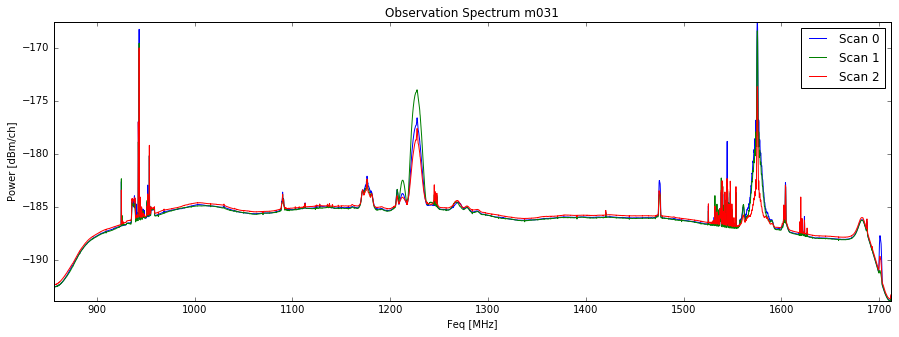

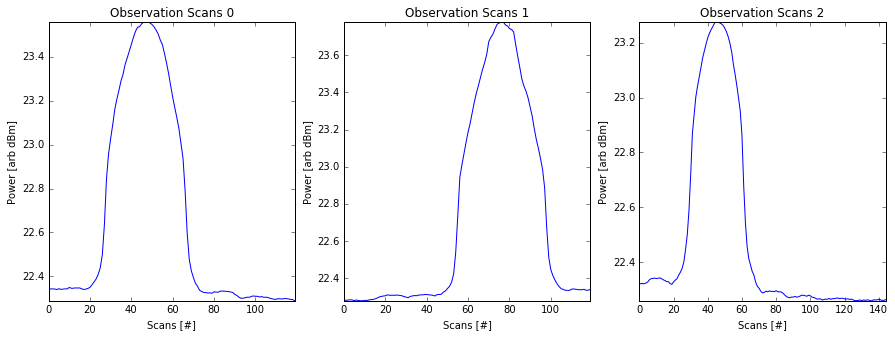

In [5]:
h5.select()
target = h5.catalogue.targets[0].name
print "GPS observation: %s" % target
passband = h5.channel_freqs
ants = h5.ants

for ant_idx in range(len(ants)):
    ant = ants[ant_idx]
    print 'Observation data for antenna %s' % ant.name
    
    # approximate Tsys using Tant values from model files
    nd_file='rx.l.%d.h.csv'%receptor_serial[ant.name]['serial']
    [nd_freqs, nd_temps, Tcal_passband] = modelTcal(os.path.join(nd_models,nd_file))
    Tsys = numpy.mean(nd_temps)

    
    Ssys = 10.*numpy.log10(k*Tsys) + 30 # dBm/Hz
    print "Expected power spectral density of the system noise floor %.2d [dBm/Hz]" % Ssys
    
    h5.select()
    h5.select(ants=ant.name,corrprods='auto',scans='scan')
    scan_indices = h5.scan_indices
    
    for idx in range(len(scan_indices)):
        h5.select(scans=scan_indices[idx])
        d = scape.DataSet(h5, baseline="%s" % (ant.name,))
        if not d is None:
            d = d.select(flagkeep='~nd_on')
        data = d.scans[0].data[:,:,0]

        # power calibration scale factor
        buff_chan = len(passband)/10
        bp_floor =  (10*numpy.log10(numpy.median(numpy.abs(data), axis=0)))[buff_chan:-buff_chan].mean()
        delta_P = bp_floor - Ssys
        
        plt.figure(2*ant_idx,figsize = (15,5))
        plt.plot(passband/1e6, 10*numpy.log10(numpy.median(numpy.abs(data), axis=0))-delta_P, label='Scan %d'%idx)       
        plt.axis('tight')
        plt.xlabel('Feq [MHz]')
        plt.ylabel('Power [dBm/ch]')
        plt.title('Observation Spectrum %s'%ant.name)
        plt.legend(loc=0)
        plt.figure(2*ant_idx+1,figsize = (15,5))
        plt.subplot(1,3,idx+1)
        plt.plot(10*numpy.log10(numpy.median(numpy.abs(data), axis=1)))
        plt.axis('tight')
        plt.xlabel('Scans [#]')
        plt.ylabel('Power [arb dBm]')
        plt.title('Observation Scans %d'%idx)
        plt.subplots_adjust(wspace=None, hspace=None)